In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 
## Univariate analysis for one numerical var
##

# y = pd.Series 

## plot hist : 
def plot_hist_y(y,fig_name = None):
    nb_bins = min(20, len(np.unique(y.values)))
    plt.hist(y, bins = nb_bins, color='steelblue', edgecolor='none')
    plt.title("Histogram of "+y.name)
    plt.xlabel("score")
    if fig_name is not None : 
        plt.savefig(res_path+"figures/"+fig_name)
    plt.show()

def repartition_and_hist(data,var,figsize=(10,5)):
    # data = pd.DataFrame
    # var = colname in data

    tmp = data.loc[~data[var].isna(), var]

    plt.figure(figsize=figsize)
    ## sorted plot
    plt.subplot(1,2,1)
    plt.plot(range(len(tmp)),tmp.sort_values())
    plt.xticks(rotation='vertical')

    plt.title(var)
    ## hist 
    plt.subplot(1,2,2)
    nb_bins = len(np.unique(tmp.values))
    plt.hist(tmp, bins=nb_bins, color='steelblue', edgecolor='none')
    plt.xticks(rotation='vertical')
    plt.title("Histogram of "+tmp.name)
plt.show()

def plot_multi_hist(data, list_of_var, x_rotate = False, figsize=(18, 20), fig_name=None) : 
    nb_line_plot = int(np.floor(len(list_of_var)/4)+1)
    fig = plt.figure(figsize=figsize)

    fig_count = 1
    for var in list_of_var :#data.columns.intersection(list_of_nutri_facts):
        ax = fig.add_subplot(nb_line_plot,4, fig_count)
        nb_bins = min(20, len(np.unique(data[var].dropna().values)))
        ax.hist(data[var], bins = nb_bins, density=True, edgecolor='none')
        ax.set_title(var)
        fig_count += 1
    if fig_name is not None :
        plt.savefig(res_path+"figures/"+fig_name)
    plt.show()

## lorenz curve : 
def plot_lorenz_curve(y):
    n = len(y)
    y_rescaled = y - min(y)
    lorenz = np.cumsum(np.sort(y_rescaled)) / y_rescaled.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    fig, ax = plt.subplots()

    ax.axis('scaled')
    xaxis = np.linspace(0-1/n,1+1/n,n+1) 
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.plot([0,0],[-0.05,1.05], color="grey") # y axis 
    plt.plot([-0.05,1.05],[0,0], color="grey") # x axis
    plt.plot([-0.05,1.05],[-0.05,1.05], "--") # identity line

    plt.xlabel("Cumulative share of buildings")
    plt.ylabel("Cumulative share of score")
    plt.title("Lorenz curve for the Energy Star score")

    plt.show()

    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    print("gini =", gini)
    print("AUC =", AUC)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
import preprocess
import missing_values_treatment
import univariate_analysis

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer


In [3]:
df_2015 = pd.read_csv(data_path+"2015-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)
df_2016 = pd.read_csv(data_path+"2016-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)

print("In 2015 data :", df_2015.shape[0],
      " buildings and ", df_2015.shape[1],"variables")
print("Total NaNs = ", df_2015.isna().sum().sum(), 
      "(that is ",np.round(100*df_2015.isna().sum().sum()/(
        df_2015.shape[0]*df_2015.shape[1]),2), "%)")

In 2015 data : 3340  buildings and  47 variables
Total NaNs =  26512 (that is  16.89 %)


# Variable type : 
First of all, it is essential to know what variable is relevant for my study. I used the graphical histogram or sorted plot of the variable serie, and I compared that to [the original page on Seattle data website](https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) to determine what type each variable is. It allowed me to separate numerical, categorical and identification variable :  

array([1, 2, 3, 4, 5, 6, 7])

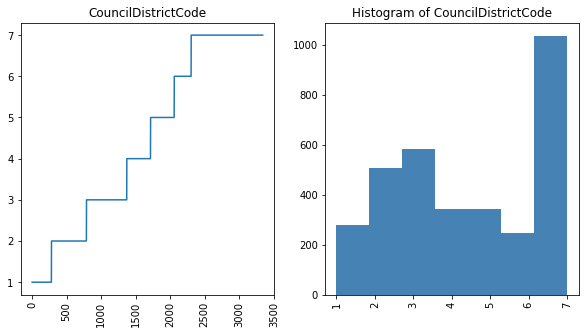

In [13]:
numerical_var = ["NumberofFloors","PropertyGFATotal",
                 "PropertyGFAParking",'PropertyGFABuilding(s)',
                 'ENERGYSTARScore',
                 'SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)',
                 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 
                 'SteamUse(kBtu)','Electricity(kWh)',
                 'Electricity(kBtu)', 'NaturalGas(therms)',
                 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
                 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
                 ]

categorical_var = ["CouncilDistrictCode",# in [1,7]
                   "2010 Census Tracts", # in [116,135]
                   "Seattle Police Department Micro Community Policing Plan Areas", # in [1,61]
                   "City Council Districts", # in [1,2]
                   "SPD Beats",# in [1,51]
                   "Zip Codes",# in [1,7]
                   "BuildingType", # txt
                   "PrimaryPropertyType", # txt
                   "Neighborhood", # txt
                   'ComplianceStatus', # "Not Compliant","Compliant"
                   ]

identification_var = ["OSEBuildingID", "DataYear","PropertyName",
                     "TaxParcelIdentificationNumber"]

unclassified = ["PropertyName", # txt
                "TaxParcelIdentificationNumber", # code for a spe tax
                "Location", # dict, hard to extract data
                "YearBuilt", # pass it into the age of the building in 2015
                'NumberofBuildings',
                ## I don't know how to treat these yet 
                "ListOfAllPropertyUseTypes"
                'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'
                'LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType',
                'YearsENERGYSTARCertified','Comment',
                'DefaultData', # "yes","no"
                'Outlier', # 'High Outlier', 'Low Outlier'
                ]

# float_var = df_2015.loc[:,df_2015.dtypes==float].columns.values
# int_var = df_2015.loc[:,df_2015.dtypes==int].columns.values

var = "CouncilDistrictCode"

repartition_and_hist(df_2015,var)

np.unique(df_2015[var])

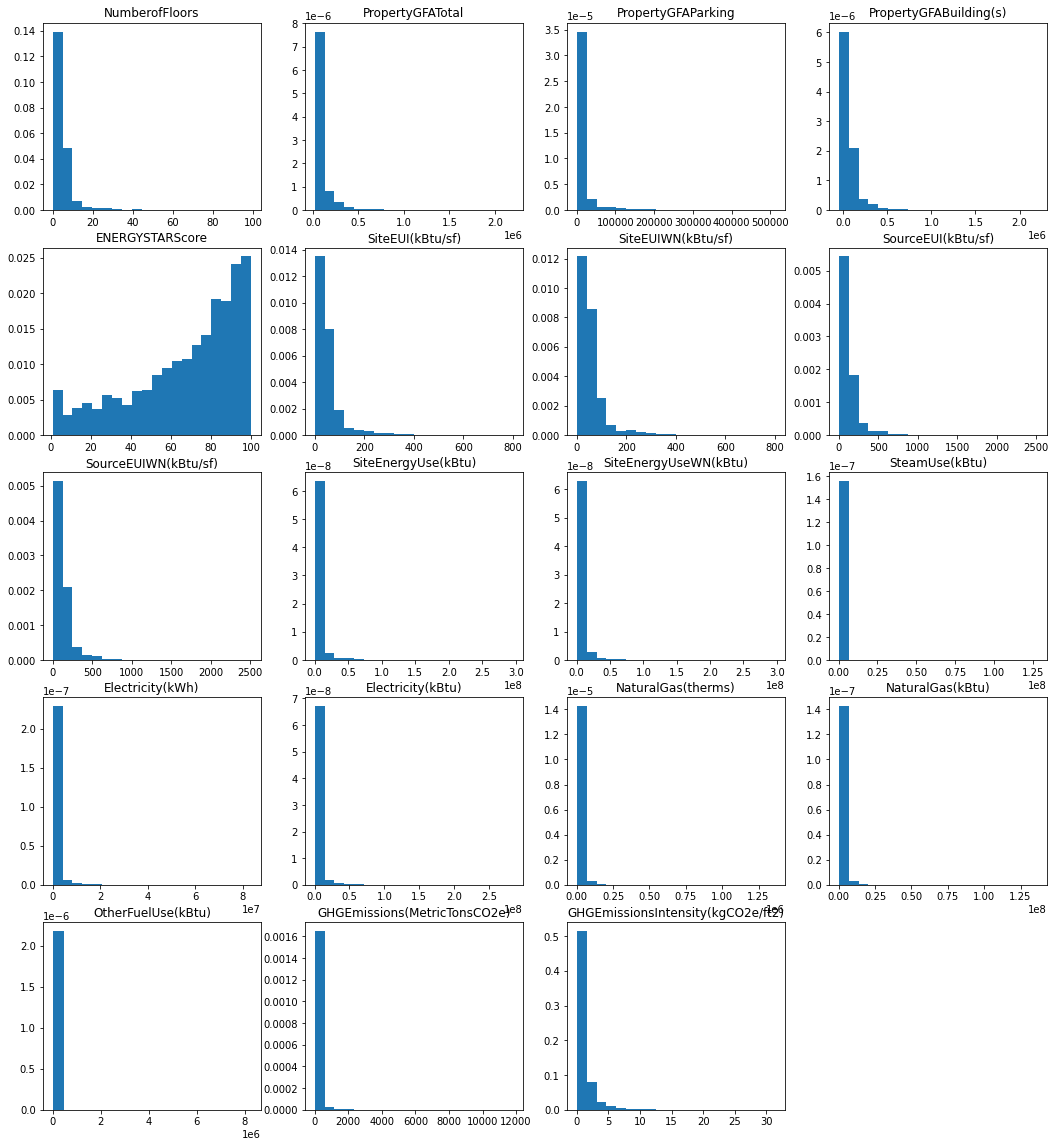

In [8]:
import univariate_analysis
plot_multi_hist(df_2015, numerical_var)
# data = df_2015
# list_of_var = numerical_var

# nb_line_plot = int(np.floor(len(list_of_var)/4)+1)
# fig = plt.figure(figsize=(18, 20))

# fig_count = 1
# for var in list_of_var :#data.columns.intersection(list_of_nutri_facts):
#     ax = fig.add_subplot(nb_line_plot,4, fig_count)
#     nb_bins = min(20, len(np.unique(data[var].dropna().values)))
#     ax.hist(data[var], bins = nb_bins, density=True, edgecolor='none', orientation="vertical")
#     ax.set_title(var)
#     fig_count += 1
#     if np.any(data[var]>1000) :
#         plt.xticks(rotation='vertical')
# if fig_name is not None :
#     plt.savefig(res_path+"figures/"+fig_name)
# plt.show()

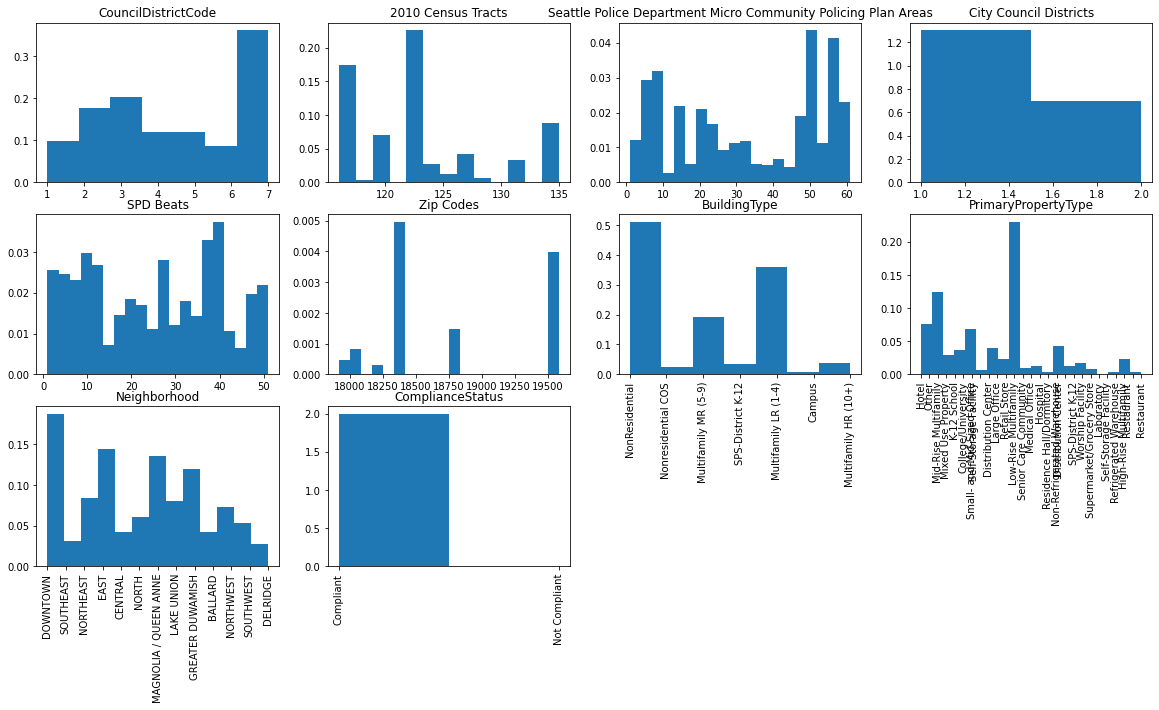

In [9]:
def plot_multi_hist(data, list_of_var, x_rotate = False, figsize=(18, 20), fig_name=None) : 
    nb_line_plot = int(np.floor(len(list_of_var)/4)+1)
    fig = plt.figure(figsize=figsize)
    fig_count = 1
    for var in list_of_var :#data.columns.intersection(list_of_nutri_facts):
        ax = fig.add_subplot(nb_line_plot,4, fig_count)
        nb_bins = min(20, len(np.unique(data[var].dropna().values)))
        ax.hist(data[var], bins = nb_bins, density=True, edgecolor='none',
                   orientation = "vertical")
        if type(data[var].values[0])==str :
            plt.xticks(rotation='vertical')
        ax.set_title(var)
        fig_count += 1
    if fig_name is not None :
        plt.savefig(res_path+"figures/"+fig_name)
    plt.show()
    
plot_multi_hist(df_2015, categorical_var, figsize=(20,10))

In [10]:
tmp = pd.concat([df_2016,df_2015],keys=["2016","2015"])

dict_agg = {key:'.mean' for key in numerical_var}
non_num_var = df_2016.columns[[var not in numerical_var for var in df_2016.columns]]
dict_agg.update({key:'.first' for key in non_num_var})

tmp.groupby("OSEBuildingID").apply(dict_agg)


TypeError: unhashable type: 'dict'

In [100]:
dict_agg

{'NumberofFloors': '.mean',
 'PropertyGFATotal': '.mean',
 'PropertyGFAParking': '.mean',
 'PropertyGFABuilding(s)': '.mean',
 'ENERGYSTARScore': '.mean',
 'SiteEUI(kBtu/sf)': '.mean',
 'SiteEUIWN(kBtu/sf)': '.mean',
 'SourceEUI(kBtu/sf)': '.mean',
 'SourceEUIWN(kBtu/sf)': '.mean',
 'SiteEnergyUse(kBtu)': '.mean',
 'SiteEnergyUseWN(kBtu)': '.mean',
 'SteamUse(kBtu)': '.mean',
 'Electricity(kWh)': '.mean',
 'Electricity(kBtu)': '.mean',
 'NaturalGas(therms)': '.mean',
 'NaturalGas(kBtu)': '.mean',
 'OtherFuelUse(kBtu)': '.mean',
 'GHGEmissions(MetricTonsCO2e)': '.mean',
 'GHGEmissionsIntensity(kgCO2e/ft2)': '.mean',
 'OSEBuildingID': '.first',
 'DataYear': '.first',
 'BuildingType': '.first',
 'PrimaryPropertyType': '.first',
 'PropertyName': '.first',
 'Address': '.first',
 'City': '.first',
 'State': '.first',
 'ZipCode': '.first',
 'TaxParcelIdentificationNumber': '.first',
 'CouncilDistrictCode': '.first',
 'Neighborhood': '.first',
 'Latitude': '.first',
 'Longitude': '.first',
 'Y

In [53]:
float_var = df_2015.loc[:,df_2015.dtypes==float].columns.values
int_var = df_2015.loc[:,df_2015.dtypes==int].columns.values

all_num_var = np.concatenate((float_var,int_var))
data = df_2015.loc[:,np.append(all_num_var,"OSEBuildingID")]
df_2015[categorical_var]

array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype=object)

## Prétraitement 
Les types semblent corrects (vérifiés avec df.dtypes). 

##### Gestion des doublons :

In [206]:
data = df_2015.loc[:,np.append(np.array(float_var),"OSEBuildingID")]
dict_duplicates = preprocess.get_index_merge_duplicates(data, float_var, 1.15)
print(dict_duplicates)

{}


#####  Suppression colonnes vides :

In [207]:
##
## drop empty columns
##
data = df_2015.loc[:,float_var].set_index(df_2015["OSEBuildingID"])

nan_repartition = data.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.95)
data = missing_values_treatment.preprocess_drop_col_nan(data, nan_threshold)

print("I drop variables with less than", 
      data.shape[0]-np.floor(nan_threshold),
      "values")
print("That is more than", 
      np.floor(nan_threshold),
      "missing values")
print("I have dropped", len(float_var)- data.shape[1] + 2,
      "variables :",
      float_var[[var not in data.columns for var in float_var]])

I drop variables with less than 258.0 values
That is more than 3082.0 missing values
I have dropped 4 variables : ['2010 Census Tracts' 'City Council Districts']


In [208]:
float_var = data.columns[[var not in ["ENERGYSTARScore", "OSEBuildingID"] for var in data.columns]]
X = data[float_var]
y = data["ENERGYSTARScore"]


##### Inférence valeurs manquantes : 

MSE = 131.642 (+/-23.211) for {'n_neighbors': 1}
MSE = 116.114 (+/-13.146) for {'n_neighbors': 2}
MSE = 111.882 (+/-10.362) for {'n_neighbors': 3}
MSE = 110.496 (+/-10.746) for {'n_neighbors': 4}
MSE = 110.178 (+/-11.167) for {'n_neighbors': 5}
MSE = 110.570 (+/-11.347) for {'n_neighbors': 6}
MSE = 110.877 (+/-11.766) for {'n_neighbors': 7}
MSE = 111.173 (+/-11.955) for {'n_neighbors': 8}
MSE = 111.373 (+/-12.669) for {'n_neighbors': 9}
MSE = 111.522 (+/-13.120) for {'n_neighbors': 10}
MSE = 111.627 (+/-13.281) for {'n_neighbors': 11}
MSE = 111.866 (+/-13.065) for {'n_neighbors': 12}
MSE = 112.016 (+/-13.351) for {'n_neighbors': 13}
MSE = 112.140 (+/-13.771) for {'n_neighbors': 14}
MSE = 112.218 (+/-14.038) for {'n_neighbors': 15}
MSE = 112.370 (+/-14.009) for {'n_neighbors': 16}
MSE = 112.547 (+/-14.098) for {'n_neighbors': 17}
MSE = 112.621 (+/-13.980) for {'n_neighbors': 18}
MSE = 112.725 (+/-14.100) for {'n_neighbors': 19}
MSE = 112.934 (+/-14.236) for {'n_neighbors': 20}
MSE = 113

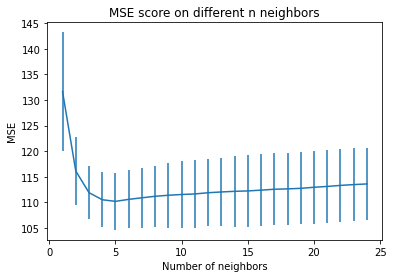

In [209]:
##
## Standardize X : 
##

standardizer = preprocessing.StandardScaler().fit(X)
X_std = standardizer.transform(X)
X_std = pd.DataFrame(X_std, columns= X.columns, index = X.index)

# ##
# ## Set the best number of neighbors
# ##

my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,25,1)}
cv = 3

# res = missing_values_treatment.launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)
# # Save dictionnary of results : 
# import pickle
# with open(res_path+"set_n_KNN_impute"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

import pickle
with open(res_path+"set_n_KNN_impute"+".pkl", "rb") as f :
        res = pickle.load(f)

fig_name = "set_n_KNN_impute.jpg"
missing_values_treatment.plot_MSE_scores_KNN_impute(res, param_grid, fig_name)

In [210]:
## Impute missing values :
imputer = KNNImputer(n_neighbors=4)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = standardizer.inverse_transform(pred_std)
pred = pd.DataFrame(pred, index = X.index, columns = X.columns)


##### Retrait des bâtiments sans le score : 

In [211]:
index_to_drop = data[data["ENERGYSTARScore"].isna().values].index
data = data.drop(index_to_drop,axis=0)

X = data[float_var]
X_pred = pred.drop(index_to_drop,axis=0)
y = data["ENERGYSTARScore"]

## Etude des variables descriptives numériques

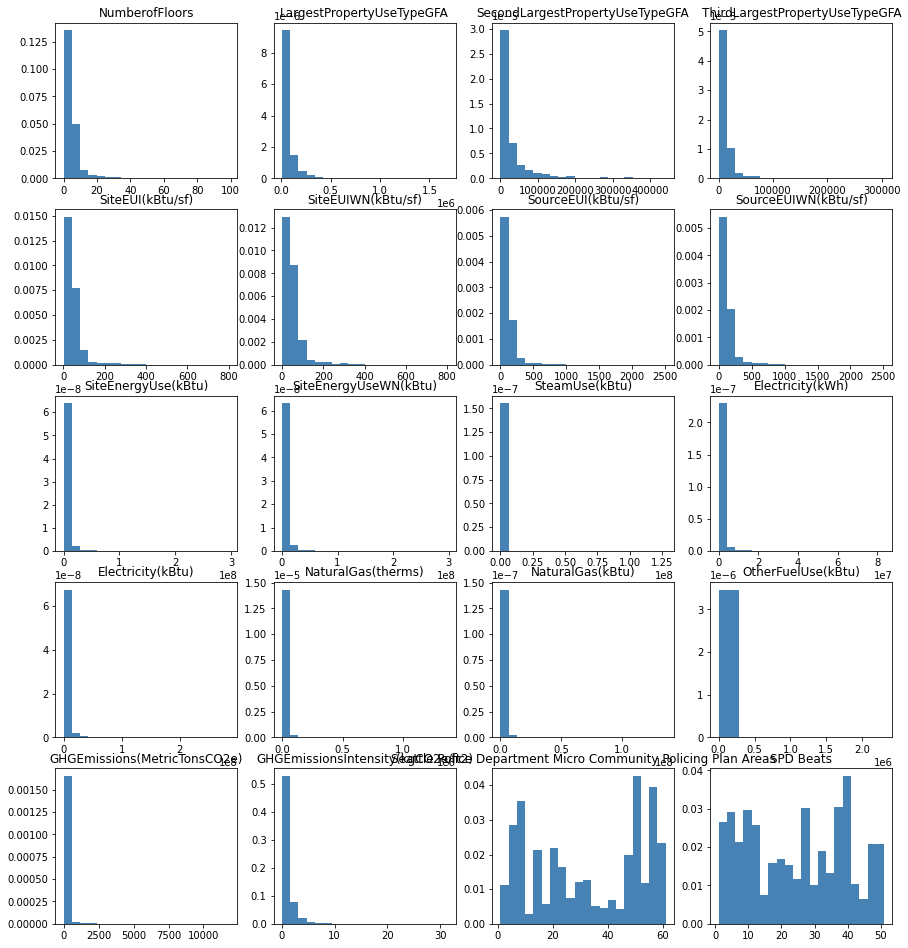

In [58]:
nb_line_plot = int(np.floor(len(float_var)/4)+1)
fig = plt.figure(figsize=(15, 20))

fig_count = 1
for var in float_var :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,4, fig_count)
    nb_bins = min(20, len(np.unique(data[var].dropna().values)))
    ax.hist(data[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

In [10]:
data["Seattle Police Department Micro Community Policing Plan Areas"]
data["SPD Beats"]

OSEBuildingID
1        31.0
2        31.0
3        31.0
5        31.0
8        31.0
         ... 
50049    16.0
50055    38.0
50057     7.0
50058    48.0
50059    48.0
Name: SPD Beats, Length: 2560, dtype: float64

## Etude de la variable de réponse 

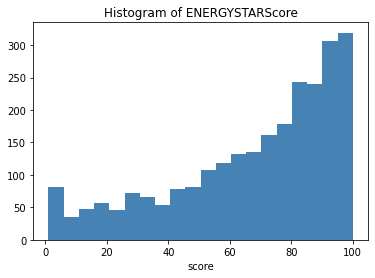

count    2560.000000
mean       67.894141
std        27.154057
min         1.000000
25%        51.750000
50%        76.000000
75%        90.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

In [11]:
import univariate_analysis

univariate_analysis.plot_hist_y(y)
    
y.describe()

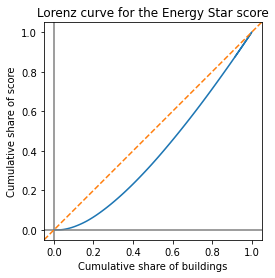

gini = 0.22380585297213407
AUC = 0.38809707351393297


In [11]:
univariate_analysis.plot_lorenz_curve(y)